### Robust Hit Policy Retrieval conditioning on the instance-specific parameters

In [1]:
import torch
import sys
sys.path.append('../')
import time
from robust_tt import RTT 
import tntorch as tn
from dyn_models.dynamic_systems_mm import MiniGlof
from tt_utils import cross_approximate
import numpy as np
from tt_utils import contract_sites
torch.set_default_dtype(torch.float64)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
# dim=5
w = 1
v_max = 5
state_max = torch.tensor([0,0]).to(device) # (x, y) 
state_min =  torch.tensor([-w,-w]).to(device)

dt= 0.01
T = 1

param_max = torch.tensor([1.5, 0.8]).to(device) #(mass, mu)
param_min = torch.tensor([0.2, 0.2]).to(device) 
# n = 100
n_state = 100
n_param = 500
n_action = 100

I_max = 5 # maximum impact

action_max = torch.tensor([I_max, I_max]).to(device) # (m_x, m_y) momentum
action_min = torch.tensor([1e-6, 1e-6]).to(device) 
dyn_system = MiniGlof(state_min=state_min, state_max=state_max, action_max=action_max, action_min=action_min,dt=dt, device=device)

domain_state = [torch.linspace(state_min[i],state_max[i],n_state).to(device) for i in range(len(state_max))]
domain_param = [torch.linspace(param_min[i],param_max[i],n_param).to(device) for i in range(len(param_max))]
domain_action =[torch.linspace(action_min[i],action_max[i],n_action).to(device) for i in range(len(action_max))]
domain_state_param = domain_state + domain_param
domain_state_action = domain_state + domain_action

In [4]:
def reward_func(state, action):
    cost = (torch.linalg.norm(state, dim=-1))**2 + (torch.linalg.norm(action, dim=-1)/100)**2*0.01
    rewards = -1*cost
    return rewards

In [5]:
def dynamics(state_param, I):
    pos = state_param[:, :2]
    m = state_param[:, 2].view(-1,1)
    u = state_param[:, 3].view(-1,1)
    t = torch.linalg.norm(I, dim=-1)[:, None]/(m*torch.linalg.norm(u*9.81, dim=-1)[:, None])
    # print(t.shape)
    acc = u*9.81* I/torch.linalg.norm(I, dim=-1)[:, None]
    state = pos + I/m * t - 0.5*acc*t**2

    return state

In [6]:

def function(x, flag='train'):  # Input arguments are vectors
    state_param = x[:, :4]
    I = x[:, 4:]
    state = dynamics(state_param, I)
    if flag=='test':
        print("state", state)
    r = reward_func(state, I)
    return r

In [7]:

domain = domain_state_param + domain_action
t0 = time.time()
adv_model = cross_approximate(fcn=function, max_batch=10**4, domain=domain, device=device, verbose=True)
print("time for function approximation:", time.time()-t0)
print("advantage function in TT format:", adv_model)

cross device is cuda
Cross-approximation over a 6D domain containing 2.5e+13 grid points:
iter: 0  | eps: 3.082e-01 | time:   0.6901 | largest rank:   1
iter: 1  | eps: 2.698e-05 | time:   0.7189 | largest rank:   4 <- converged: eps < 0.0001
Did 42300 function evaluations, which took 0.006001s (7.048e+06 evals/s)

time for function approximation: 0.75156569480896
advantage function in TT format: 6D TT tensor:

 100 100 500 500 100 100
  |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5)
 / \ / \ / \ / \ / \ / \
1   3   4   4   4   4   1



In [8]:

### Given policy in TT format, conditioning on the state and param, find the optimal action
def forward_model(state_param,action):
    return dyn_system.fwd_simulate(state_param,action)

def reward(state_param,action):
    rewards = dyn_system.reward_state_action(state_param,action)
    return rewards

rtt = RTT(domain_state=domain_state+domain_param, domain_param=domain_param,
                domain_action=domain_action, 
                reward=reward, 
                normalize_reward=False,
                forward_model=forward_model, 
                gamma=0.99, dt=dt,
                rmax_v=100, rmax_a=100, 
                nswp_v=5, nswp_a=5, 
                kickrank_v=10, kickrank_a=20,
                max_batch_v=10**4,max_batch_a=10**5,
                eps_cross_v=1e-3,
                eps_cross_a=1e-3,
                eps_round_v=1e-4, 
                eps_round_a=1e-3, 
                n_samples=100, 
                verbose=True,
                device=device) # action = 'deterministic_tt', 'stochastic_tt', 'random'

In [9]:

rtt.a_model = adv_model
policy_model = rtt.normalize_tt_a(adv_model)
rtt.policy_model = policy_model
rtt.policy_model_cores = policy_model.tt().cores[:]


### Policy retrieval through domain contaction

In [10]:
# initialize the test state
n_test = 100
dim_state = len(domain_state)
init_state = torch.zeros((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)

In [11]:
tol = torch.tensor([0.10, 0.10]).to(device)
def contract_callback(rtt, state, policy_model, real_param, T=1,  animation=False):
    print("Testing....")

    traj = state[:,:2].clone()[:,None,:]
    
    impact = rtt.policy_ttgo_contract(state, policy_model, device=device)
    m = real_param[:, 0].view(-1,1)
    u = real_param[:, 1].view(-1,1)
    acc = u*9.81* impact/torch.linalg.norm(impact, dim=-1)[:, None]
    acc = torch.clamp(acc, min=-10, max=0)
    state_param = torch.cat((state, real_param), dim=1)
    final_state = dynamics(state_param, impact)

    print("Final state: ", final_state[:10])

    #generate trajectory for plot
    num_points = int(T/dt)  
    alpha = torch.linspace(0, 1, steps=num_points, device=state.device).view(1, num_points, 1)
    state_exp = state[:, None, :]
    final_exp = final_state[:, None, :]
    traj = state_exp + alpha * (final_exp - state_exp)
    
    suc_rate = torch.sum(torch.all(torch.abs(final_state[:,:2])<=tol[:2], dim=1))/n_test
    print("Success rate: ", suc_rate)

    from matplotlib import pyplot as plt
    from plot_utils import plot_point_mass
    plt=plot_point_mass(traj[:10, :,:2].to('cpu'),x_target=torch.tensor([0,0]).to('cpu'), figsize=5, xmax=1)
    plt.grid()
    plt.show()
    

Testing....
Final state:  tensor([[ 0.005909, -0.000349],
        [-0.026554,  0.003257],
        [-0.000452,  0.010879],
        [ 0.001731,  0.000159],
        [-0.006698, -0.002717],
        [-0.004361, -0.003248],
        [ 0.005264, -0.003234],
        [ 0.007779, -0.003025],
        [-0.002026, -0.001801],
        [ 0.004305,  0.001605]], device='cuda:0')
Success rate:  tensor(0.980000, device='cuda:0')


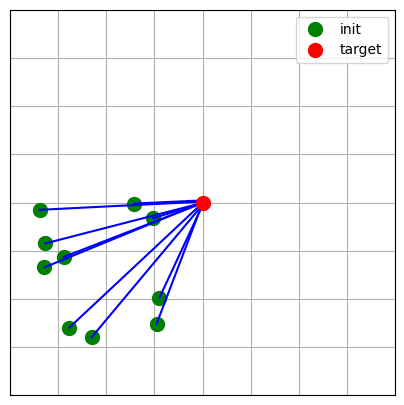

In [12]:
site_x = [2, 3]
num_para = len(site_x)

# initialize the real parameter
mean_id = torch.randint(0, n_param-1, (num_para,)).to(device)
real_param = torch.zeros(num_para).to(device)
for i in range(num_para):
    real_param[i] = domain_param[i][mean_id[i]]
real_param = real_param.view(1,-1).expand(n_test,-1).to(device)

# get parameter-conditioned advantage function through domain contraction
rtt.domain_state_action = domain_state + domain_action # the previous domain_state_action is domain_state + domain_param + domain_action
contract_policy_model = rtt.get_contract_policy(site_x=site_x, mean_id=mean_id, sigma=n_param, length=n_param*1/100, flag = 'uniform', device=device)

contract_callback(rtt, state, contract_policy_model, real_param, T=T, animation=False)